# Simple 2D Sparse GP
We will test to ensure that our sparse GP implementation works correctly in this notebook.

## Generate Syntethic Data
We generate a simple dataset for testing with inputs in the range [0, 200]. We'll use a sinusoidal function with some noise added.

In [23]:
import jax
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
from jax.scipy.linalg import cho_factor, cho_solve
import imageio
import os

from kernels import *
from sparse_gp import *

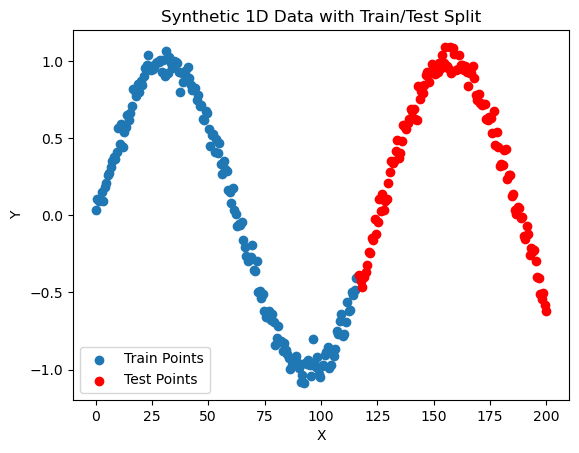

In [24]:
# Inputs
X = onp.linspace(0, 200, 300).reshape(-1, 1)

# Outputs: Sine function with noise
Y = onp.sin(X * 0.05) + 0.05 * onp.random.normal(size=X.shape)

# Training and testing split
X_train, Y_train = X[:175], Y[:175]
X_test, Y_test = X[175:], Y[175:]

# Plot data
plt.scatter(X_train, Y_train, label="Train Points")
plt.scatter(X_test, Y_test, label="Test Points", color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Synthetic 1D Data with Train/Test Split")
plt.show()

## Plotting Code
### Predictive Mean and Uncertainty Plot

In [25]:
def plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, model_fn):
    # Ensure input arrays are two-dimensional
    X_test = X_test.reshape(-1, 1)
    X_train = X_train.reshape(-1, 1)
    Z = Z.reshape(-1, 1)
    numInducing = Z.shape[0]

    # Make predictions on the test set using the optimized hyperparameters
    posterior_mean, posterior_var = model_fn(X_test, X_train, Y_train, Z, optimized_hyperparams)

    # Convert JAX arrays to NumPy arrays for plotting and ensure all are 1D
    posterior_mean = onp.array(posterior_mean).flatten()
    posterior_var = onp.array(posterior_var).flatten()
    X_test = onp.array(X_test).flatten()

    # Ensure all variances are positive
    posterior_var = onp.maximum(posterior_var, 1e-10)

    # Plot the points, predictive mean, and confidence interval
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train, Y_train, color='blue', label="Training Points")
    plt.scatter(X_test, Y_test, color='red', label="Test Points")

    # Plot predictive mean line and 95% confidence interval
    plt.plot(X_test, posterior_mean, 'green', label="Predicted Mean")
    plt.fill_between(X_test,
                     (posterior_mean - 1.96 * onp.sqrt(posterior_var)),
                     (posterior_mean + 1.96 * onp.sqrt(posterior_var)),
                     color='green', alpha=0.2, label="95% Confidence Interval")

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
    plt.title(f"Sparse GP Prediction with Uncertainty (Including {numInducing} Inducing Points)")
    plt.show()
#

### Negative Log Predictive Density Plot

In [26]:
def calculate_nlpd(X, Y, Z, hyperparams, model_fn, noise_variance):
    posterior_mean, posterior_var = model_fn(X, X_train, Y_train, Z, hyperparams)
    nlpd = neg_log_predictive_density(Y, posterior_mean, posterior_var, noise_variance)
    return nlpd
#

### ELBO Plot

In [27]:
def plot_elbo(history):
    # Extract ELBO values and steps from history
    elbo_values = [entry["elbo"] for entry in history]
    steps = [entry["step"] for entry in history]
    
    # Plot the ELBO values over steps
    plt.figure(figsize=(10, 5))
    plt.plot(steps, elbo_values, label="ELBO", color='blue')
    plt.xlabel("Step")
    plt.ylabel("ELBO")
    plt.title("ELBO Over Training Steps")
    plt.legend()
    plt.show()
#

### Kernel Hyperparameter Plot

In [28]:
def plot_kernel_hyperparameters(history, num_spectral_mixtures=10, dims=1):
    """
    Plot kernel hyperparameters over training steps, including individual mixtures for the spectral mixture kernel.
    
    Arguments:
    - history: List of dictionaries containing step and hyperparameters.
    - num_spectral_mixtures: Number of mixtures in the spectral mixture kernel.
    - dims: Number of dimensions for the spectral mixture kernel.
    """
    # Extract training steps
    steps = [entry["step"] for entry in history]
    
    # Function to normalize values between 0 and 1
    def normalize(values):
        min_val, max_val = min(values), max(values)
        return [(v - min_val) / (max_val - min_val) for v in values] if max_val > min_val else values
    #

    # Extract and normalize raw hyperparameters
    weights_1 = normalize([entry["hyperparams"][0] for entry in history])
    weights_2 = normalize([entry["hyperparams"][1] for entry in history])
    weights_3 = normalize([entry["hyperparams"][2] for entry in history])
    
    signal_variance_sqexp = normalize([entry["hyperparams"][4] for entry in history])
    length_scale_sqexp = normalize([entry["hyperparams"][5] for entry in history])
    signal_variance_linear = normalize([entry["hyperparams"][7] for entry in history])
    signal_variance_matern = normalize([entry["hyperparams"][9] for entry in history])
    length_scale_matern = normalize([entry["hyperparams"][10] for entry in history])
    
    signal_variance_sinusoidal = normalize([entry["hyperparams"][13] for entry in history])
    period_sinusoidal = normalize([entry["hyperparams"][14] for entry in history])
    length_scale_sinusoidal = normalize([entry["hyperparams"][15] for entry in history])

    # Spectral mixture kernel hyperparameters
    sm_offset = 16  # Offset for the spectral mixture kernel parameters
    spectral_mixture_weights = [
        normalize([entry["hyperparams"][sm_offset + i * (1 + 2 * dims)] for entry in history])
        for i in range(num_spectral_mixtures)
    ]
    spectral_mixture_means = [
        [
            normalize([entry["hyperparams"][sm_offset + 1 + i * (1 + 2 * dims) + j] for entry in history])
            for j in range(dims)
        ]
        for i in range(num_spectral_mixtures)
    ]
    spectral_mixture_variances = [
        [
            normalize([entry["hyperparams"][sm_offset + 1 + dims + i * (1 + 2 * dims) + j] for entry in history])
            for j in range(dims)
        ]
        for i in range(num_spectral_mixtures)
    ]

    # Plot normalized kernel hyperparameters
    plt.figure(figsize=(12, 8))

    # Plot for Squared-Exponential Kernel
    plt.plot(steps, weights_1, label="Weight (Squared-Exponential)", color='blue', linestyle='--')
    plt.plot(steps, signal_variance_sqexp, label="Signal Variance (Sq-Exp)", color='blue', linestyle='-')
    plt.plot(steps, length_scale_sqexp, label="Length Scale (Sq-Exp)", color='blue', linestyle=':')

    # Plot for Linear Kernel
    plt.plot(steps, weights_2, label="Weight (Linear)", color='red', linestyle='--')
    plt.plot(steps, signal_variance_linear, label="Signal Variance (Linear)", color='red', linestyle='-')

    # Plot for Matern Kernel
    plt.plot(steps, weights_3, label="Weight (Matern)", color='green', linestyle='--')
    plt.plot(steps, signal_variance_matern, label="Signal Variance (Matern)", color='green', linestyle='-')
    plt.plot(steps, length_scale_matern, label="Length Scale (Matern)", color='green', linestyle=':')

    # Plot for Sinusoidal Kernel
    plt.plot(steps, signal_variance_sinusoidal, label="Signal Variance (Sinusoidal)", color='purple', linestyle='-')
    plt.plot(steps, period_sinusoidal, label="Period (Sinusoidal)", color='purple', linestyle='--')
    plt.plot(steps, length_scale_sinusoidal, label="Length Scale (Sinusoidal)", color='purple', linestyle=':')

    # Plot for Spectral Mixture Kernel (Each mixture in a different color)
    colors = plt.cm.viridis(np.linspace(0, 1, num_spectral_mixtures))  # Generate unique colors for mixtures
    for i in range(num_spectral_mixtures):
        plt.plot(steps, spectral_mixture_weights[i], label=f"SM Weight {i + 1}", color=colors[i], linestyle='-')
        for j in range(dims):
            plt.plot(steps, spectral_mixture_means[i][j], label=f"SM Mean {i + 1}, Dim {j + 1}", color=colors[i], linestyle='--')
            plt.plot(steps, spectral_mixture_variances[i][j], label=f"SM Variance {i + 1}, Dim {j + 1}", color=colors[i], linestyle=':')

    # Plot configuration
    plt.xlabel("Step")
    plt.ylabel("Normalized Parameter Value (0 to 1)")
    plt.title("Normalized Kernel Hyperparameter Values Over Training Steps")
    plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()
    plt.show()
#

# Test Experiment 1
Test on 20 inducing points.

## Parameter Initialization

In [29]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train, num_inducing=20)

# Define a function to initialize hyperparameters for the combined kernel
def random_init_combined_hyperparams(X_train):
    # Determine the number of input dimensions from X_train
    dims = X_train.shape[1]
    
    # Three initial weights in log space for unconstrained optimization (converted to float)
    initial_weights = [float(np.log(0.33)), float(np.log(0.33)), float(np.log(0.33))]
    
    # Initial hyperparameters for each kernel
    hyperparams_sqexp = [0.1, 1.0, 10.0]        # [noise_variance, signal_variance, length_scale]
    hyperparams_linear = [0.1, 1.0]             # [noise_variance, signal_variance]
    hyperparams_matern = [0.1, 1.0, 10.0]       # [noise_variance, signal_variance, length_scale]
    hyperparams_sinusoidal = [0.1, 1.0, 10.0, 1.0]  # [noise_variance, signal_variance, period, length_scale]

    # Initialize spectral mixture hyperparameters
    num_mixtures = 5
    hyperparams_spectralmixture = [0.1]  # Start with noise_variance and number of mixtures

    for _ in range(num_mixtures):
        weight = 1 / num_mixtures  # Equal weight for each mixture initially
        mean = [0.0] * dims  # Zero mean for each dimension
        variance = [1.0] * dims  # Unit variance for each dimension
        hyperparams_spectralmixture.append(weight)  # Add weight
        hyperparams_spectralmixture.extend(mean)  # Add flattened mean
        hyperparams_spectralmixture.extend(variance)  # Add flattened variance
    #

    # Concatenate all hyperparameters
    initial_params = (
        initial_weights +
        hyperparams_sqexp +
        hyperparams_linear +
        hyperparams_matern +
        hyperparams_sinusoidal +
        hyperparams_spectralmixture
    )
    
    return np.array(initial_params, dtype=np.float32)
#


# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams(X_train)

## Define the Optimization Loop for ELBO

In [30]:
# Set the gradient ascent step size and number of steps
step_size = 5e-3
num_steps = 1000

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train, Y_train, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -194.51662243972413
Step 10, ELBO: -186.8342102387102
Step 20, ELBO: -180.81273962191534
Step 30, ELBO: -176.30784904751047
Step 40, ELBO: -173.06438623270486
Step 50, ELBO: -170.77584018227185
Step 60, ELBO: -169.15114645894982
Step 70, ELBO: -167.9587308637244
Step 80, ELBO: -167.03812716337094
Step 90, ELBO: -166.28927633105735
Step 100, ELBO: -165.6542187350896
Step 110, ELBO: -165.10055636372138
Step 120, ELBO: -164.60968418030498
Step 130, ELBO: -164.16943472681518
Step 140, ELBO: -163.769774545215
Step 150, ELBO: -163.400326845022
Step 160, ELBO: -163.0485823287505
Step 170, ELBO: -162.69767315763656
Step 180, ELBO: -162.32176632027983
Step 190, ELBO: -161.87427149243314
Step 200, ELBO: -161.25212207795357
Step 210, ELBO: -160.15735281327875
Step 220, ELBO: -157.27913300784985
Step 230, ELBO: -139.9340803735813
Step 240, ELBO: -111.6990915674467
Step 250, ELBO: -97.2662653410678
Step 260, ELBO: -84.0271550918353
Step 270, ELBO: -71.10112819257877
Step 280, ELBO: -5

In [31]:
print("Optimized Hyperparameters:", optimized_hyperparams)
print("sum of First 3 Weights:", np.sum(optimized_hyperparams[:3]))

# percentage of change in each hyperparameter
print("Percentage of change in each hyperparameter:")
for i in range(1, len(optimized_hyperparams)):
    print(f"Hyperparameter {i}: {100 * (optimized_hyperparams[i] - unconstrained_hyperparams_init[i]) / unconstrained_hyperparams_init[i]:.2f}%")

Optimized Hyperparameters: [3.7799979e+02 9.4618157e-02 1.6199249e-01 5.4417346e-03 5.2175922e-03
 2.3423650e+03 5.5462620e-03 7.7939004e-01 5.5462620e-03 1.3343678e+00
 2.2022707e+04 5.5462620e-03 1.8481879e+00 2.2026465e+04 2.7182817e+00
 5.5462620e-03 8.5447438e-02 1.4924836e+00 3.7481651e+00 8.5447438e-02
 1.4924836e+00 3.7481651e+00 8.5447438e-02 1.4924836e+00 3.7481651e+00
 8.5447438e-02 1.4924836e+00 3.7481651e+00 8.5447438e-02 1.4924836e+00
 3.7481651e+00]
sum of First 3 Weights: 378.25638
Percentage of change in each hyperparameter:
Hyperparameter 1: -108.53%
Hyperparameter 2: -114.61%
Hyperparameter 3: -94.56%
Hyperparameter 4: -99.48%
Hyperparameter 5: 23323.65%
Hyperparameter 6: -94.45%
Hyperparameter 7: -22.06%
Hyperparameter 8: -94.45%
Hyperparameter 9: 33.44%
Hyperparameter 10: 220127.08%
Hyperparameter 11: -94.45%
Hyperparameter 12: 84.82%
Hyperparameter 13: 220164.66%
Hyperparameter 14: 171.83%
Hyperparameter 15: -94.45%
Hyperparameter 16: -57.28%
Hyperparameter 17: in

## Predict and Plot the Results

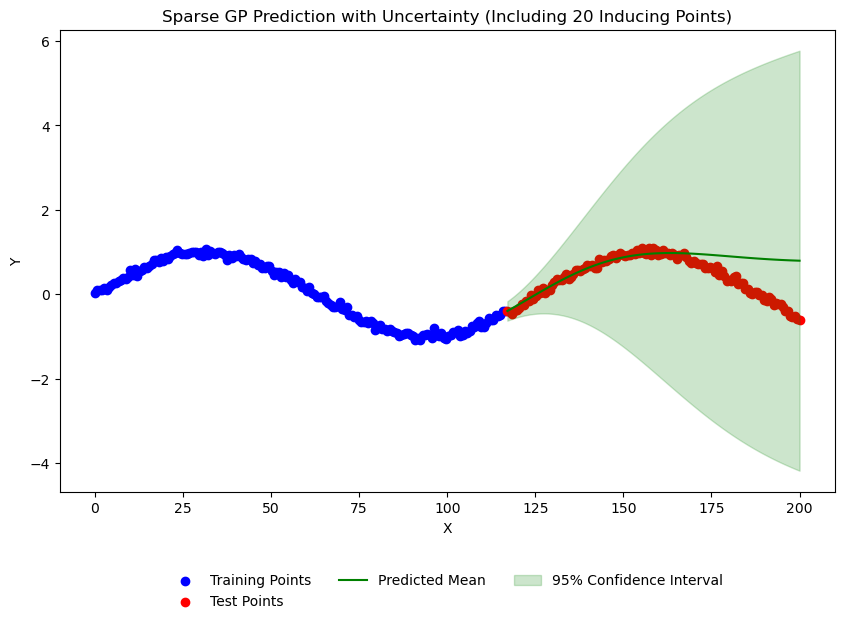

In [32]:
plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive)

In [33]:
# Extract weights
weights = optimized_hyperparams[:3]
weight_percentages = (weights / np.sum(weights)) * 100

# Print weights as percentages for each kernel
print("Kernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")
print(f"Kernel 4 (Sinusoidal): {weight_percentages[3]:.2f}%")
print(f"Kernel 5 (Spectral Mixture): {weight_percentages[4]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
# print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[3]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[4]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[5]:.4f}")
# print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[7]:.4f}")
# print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[10]:.4f}")
# print(f"Kernel 4 - Noise Variance: {optimized_hyperparams[11]:.4f}")
print(f"Kernel 4 - Signal Variance: {optimized_hyperparams[12]:.4f}")
print(f"Kernel 4 - Period: {optimized_hyperparams[13]:.4f}")
print(f"Kernel 4 - Length Scale: {optimized_hyperparams[14]:.4f}")


Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 99.93%
Kernel 2 (Linear): 0.03%
Kernel 3 (Matérn): 0.04%
Kernel 4 (Sinusoidal): 0.04%
Kernel 5 (Spectral Mixture): 0.04%

Other Hyperparameters:
Kernel 1 - Signal Variance: 0.0052
Kernel 1 - Length Scale: 2342.3650
Kernel 2 - Signal Variance: 0.7794
Kernel 3 - Signal Variance: 1.3344
Kernel 3 - Length Scale: 22022.7070
Kernel 4 - Signal Variance: 1.8482
Kernel 4 - Period: 22026.4648
Kernel 4 - Length Scale: 2.7183


## NLPD on Test Data

In [34]:
train_nlpd = calculate_nlpd(X_train, Y_train, Z, optimized_hyperparams, sparse_gp_posterior_predictive, noise_variance=optimized_hyperparams[2])
test_nlpd = calculate_nlpd(X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive, noise_variance=optimized_hyperparams[2])

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: 0.0420
Test NLPD: 1.3040


## ELBO Maximization

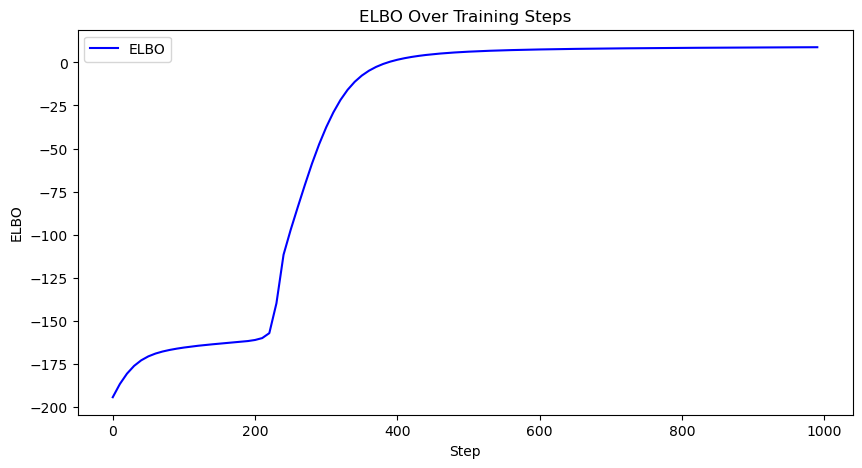

In [35]:
plot_elbo(history)

## Kernel Hyperparameters

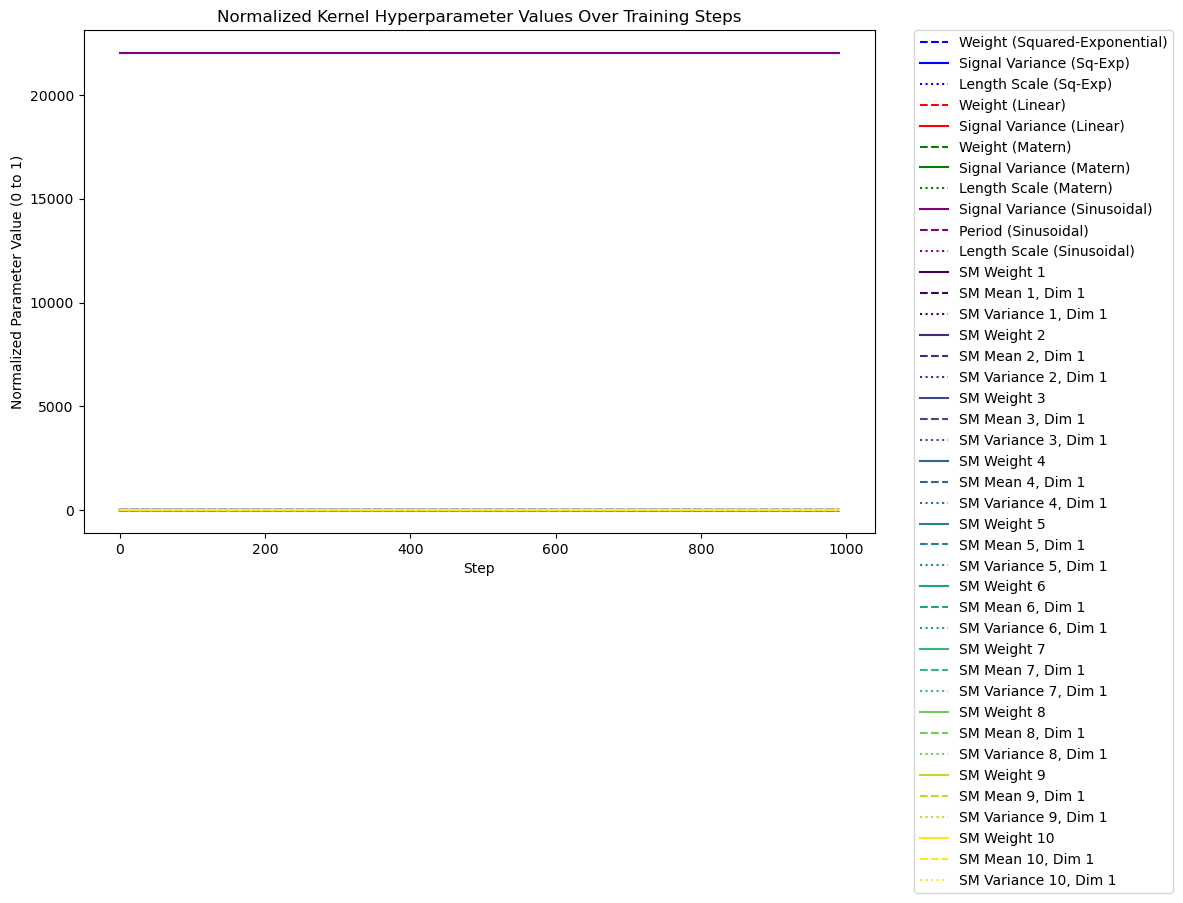

In [36]:
plot_kernel_hyperparameters(history)

# Test Experiment 2
Test on 100 inducing points.

## Parameter Initialization

In [37]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train, num_inducing=100)

# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams(X_train)

## Define the Optimization Loop for ELBO

In [38]:
# Set the gradient ascent step size and number of steps
step_size = 5e-3
num_steps = 200

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train, Y_train, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -244.67136137876437
Step 10, ELBO: -215.54657596665544
Step 20, ELBO: -195.5179573319359
Step 30, ELBO: -183.14099910871886
Step 40, ELBO: -175.3542698399295
Step 50, ELBO: -170.31959574597062
Step 60, ELBO: -167.08316828509217
Step 70, ELBO: -165.0465991650468
Step 80, ELBO: -163.78519730305743
Step 90, ELBO: -163.00059348458865
Step 100, ELBO: -162.49658038794325
Step 110, ELBO: -162.1525876411463
Step 120, ELBO: -161.89732053286946
Step 130, ELBO: -161.68794131874787
Step 140, ELBO: -161.49648120375556
Step 150, ELBO: -161.3020686669407
Step 160, ELBO: -161.0863965470666
Step 170, ELBO: -160.83011130031883
Step 180, ELBO: -160.50825924545822
Step 190, ELBO: -160.0824536289474
Optimized Hyperparameters: [4.7128278e-01 2.5705439e-01 3.2901230e-01 2.6821771e-01 4.6022639e-02
 1.1190534e+04 2.6891139e-01 2.1174161e+00 2.6891139e-01 2.7101450e+00
 2.2022412e+04 2.6891139e-01 2.6798844e+00 2.2026465e+04 2.7182817e+00
 2.6891139e-01 5.0308442e-01 1.4940963e+00 3.9550748e+00 5

In [39]:
print("Optimized Hyperparameters:", optimized_hyperparams)
print("sum of First 2 Weights:", np.sum(optimized_hyperparams[:2]))

Optimized Hyperparameters: [4.7128278e-01 2.5705439e-01 3.2901230e-01 2.6821771e-01 4.6022639e-02
 1.1190534e+04 2.6891139e-01 2.1174161e+00 2.6891139e-01 2.7101450e+00
 2.2022412e+04 2.6891139e-01 2.6798844e+00 2.2026465e+04 2.7182817e+00
 2.6891139e-01 5.0308442e-01 1.4940963e+00 3.9550748e+00 5.0308442e-01
 1.4940963e+00 3.9550748e+00 5.0308442e-01 1.4940963e+00 3.9550748e+00
 5.0308442e-01 1.4940963e+00 3.9550748e+00 5.0308442e-01 1.4940963e+00
 3.9550748e+00]
sum of First 2 Weights: 0.72833717


## Predict and Plot the Results

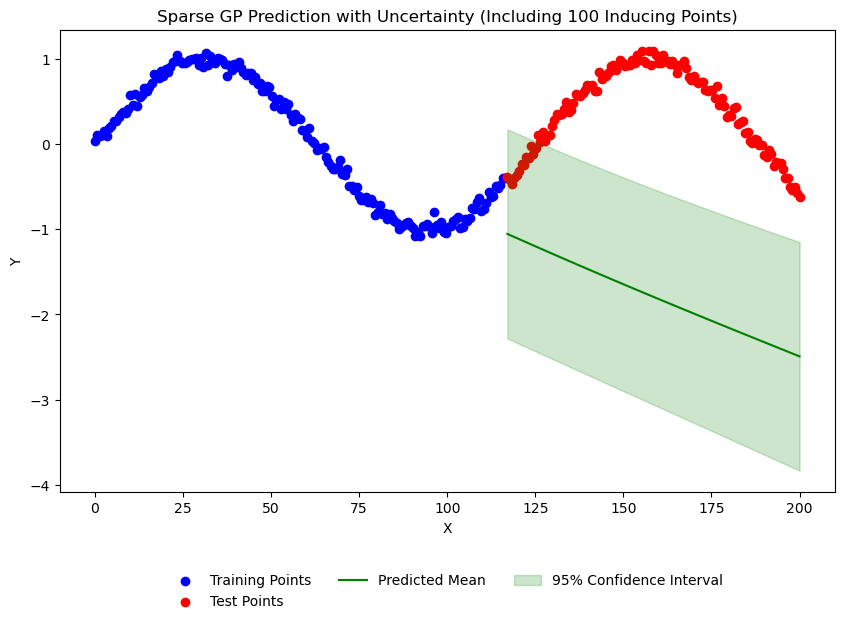

In [40]:
plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive)

In [41]:
# Extract weights
weights = optimized_hyperparams[:3]
weight_percentages = (weights / np.sum(weights)) * 100

# Print weights as percentages for each kernel
print("Kernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")
print(f"Kernel 4 (Sinusoidal): {weight_percentages[3]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
# print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[3]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[4]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[5]:.4f}")
# print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[7]:.4f}")
# print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[10]:.4f}")
# print(f"Kernel 4 - Noise Variance: {optimized_hyperparams[11]:.4f}")
print(f"Kernel 4 - Signal Variance: {optimized_hyperparams[12]:.4f}")
print(f"Kernel 4 - Period: {optimized_hyperparams[13]:.4f}")
print(f"Kernel 4 - Length Scale: {optimized_hyperparams[14]:.4f}")

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 44.57%
Kernel 2 (Linear): 24.31%
Kernel 3 (Matérn): 31.12%
Kernel 4 (Sinusoidal): 31.12%

Other Hyperparameters:
Kernel 1 - Signal Variance: 0.0460
Kernel 1 - Length Scale: 11190.5342
Kernel 2 - Signal Variance: 2.1174
Kernel 3 - Signal Variance: 2.7101
Kernel 3 - Length Scale: 22022.4121
Kernel 4 - Signal Variance: 2.6799
Kernel 4 - Period: 22026.4648
Kernel 4 - Length Scale: 2.7183


## NLPD

In [42]:
train_nlpd = calculate_nlpd(X_train, Y_train, Z, optimized_hyperparams, sparse_gp_posterior_predictive, noise_variance=optimized_hyperparams[2])
test_nlpd = calculate_nlpd(X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive, noise_variance=optimized_hyperparams[2])

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: 0.7802
Test NLPD: 4.2361


## ELBO Maximization


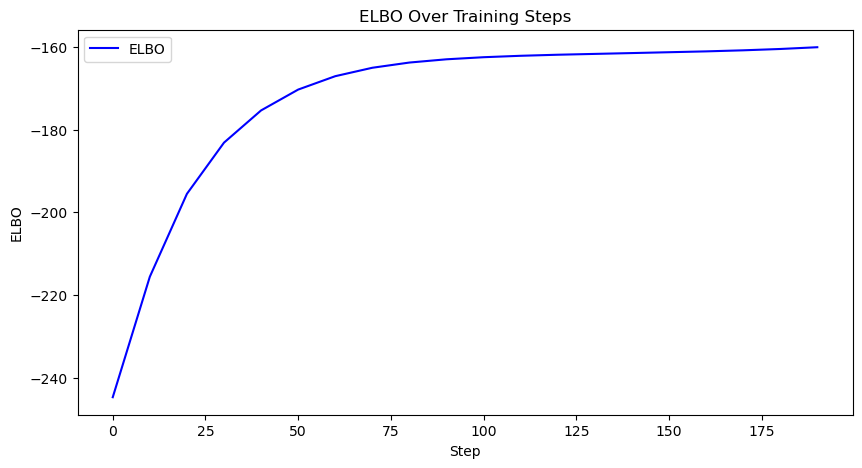

In [43]:
plot_elbo(history)

## Kernel Hyperparameters

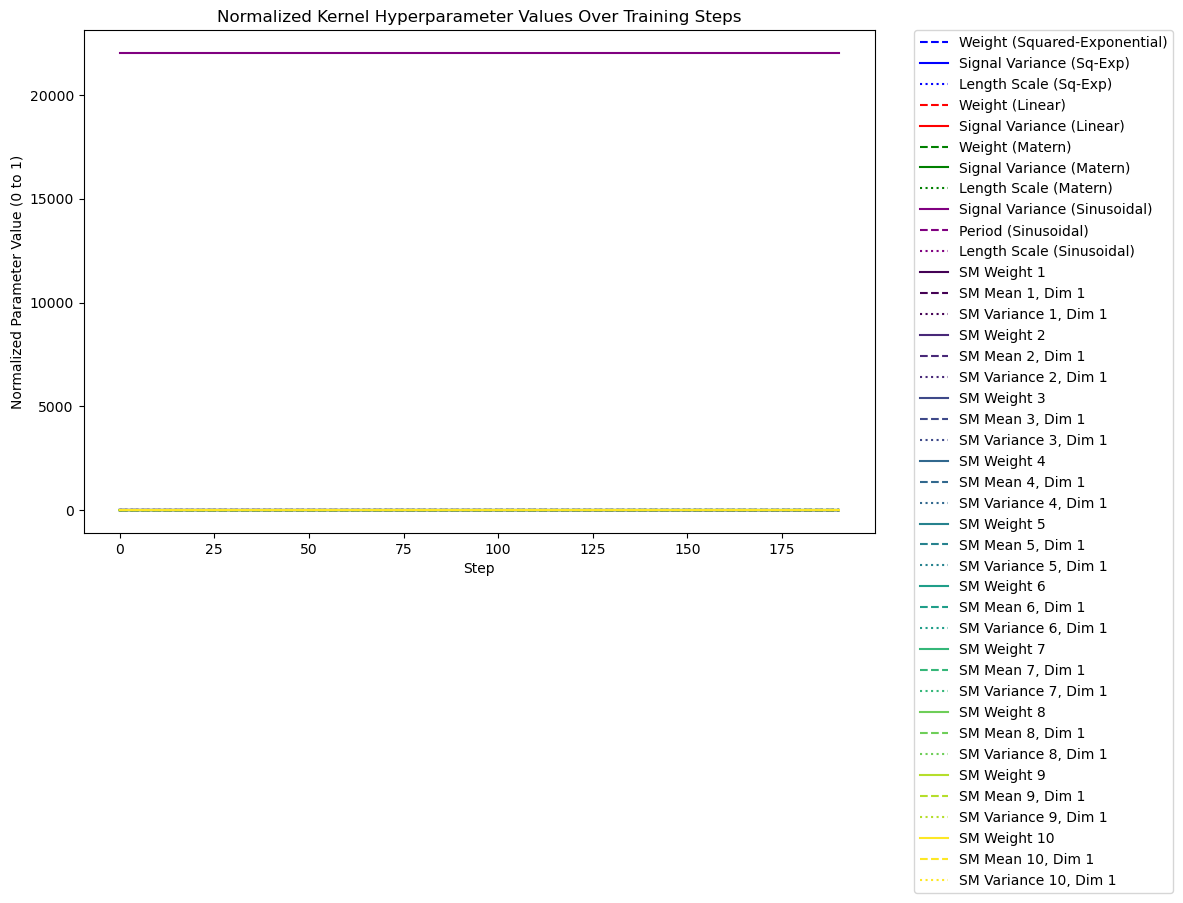

In [44]:
plot_kernel_hyperparameters(history)